In [1]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.1MB/s 


In [2]:
!pip install imblearn

In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import RUSBoostClassifier
from lightgbm import plot_importance
from lightgbm.sklearn import LGBMClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.inspection import permutation_importance
from sklearn.metrics import (plot_confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             log_loss, 
                             precision_score,
                             recall_score, 
                             f1_score)
from hyperopt import fmin, hp, Trials, tpe
from functools import partial
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from category_encoders.wrapper import PolynomialWrapper
from collections import Counter
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [4]:
df_trn = pd.read_csv('/content/train_yaOffsB.csv')
df_tst = pd.read_csv('/content/test_pFkWwen.csv')
df_sub = pd.read_csv('/content/sample_submission_O1oDc4H.csv')

df_trn.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,79858.000000,88858.000000,88858.000000,88858.000000
mean,1399.012210,0.284375,0.458417,2.264186,25.849952,28.623970,9.589986,1.896959,0.190562
std,849.048781,0.451119,0.498271,0.461772,15.554428,12.391881,9.900631,0.701322,0.454215
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [5]:
df_trn = df_trn[~((df_trn['Crop_Damage'] == 2) & (df_trn['Pesticide_Use_Category'] == 1))]

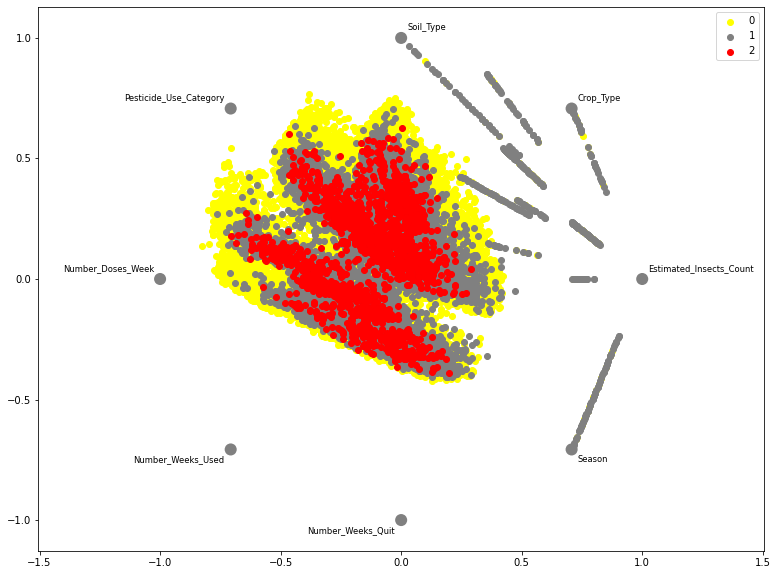

In [6]:
plt.figure(figsize=(13,10))
pd.plotting.radviz(df_trn.select_dtypes('number'), 'Crop_Damage', color=('yellow', 'gray', 'red'))
plt.show()

In [7]:
df_trn['Test'] = 0
df_tst['Test'] = 1

df_trn.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,Test
0,F00000001,188,1,0,1,0,0.0,0,1,0,0
1,F00000003,209,1,0,1,0,0.0,0,2,1,0
2,F00000004,257,1,0,1,0,0.0,0,2,1,0
3,F00000005,257,1,1,1,0,0.0,0,2,1,0
4,F00000006,342,1,0,1,0,0.0,0,2,1,0


In [8]:
df_tst.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Test
0,F00000002,188,1,1,1,0,NaN,0,2,1
1,F00000007,410,1,1,1,0,0.0,0,2,1
2,F00000011,626,1,0,1,0,0.0,0,2,1
3,F00000013,731,1,0,1,0,0.0,0,2,1
4,F00000014,789,0,0,1,0,0.0,0,1,1


In [ ]:
#oversample = RandomOverSampler(random_state=3)
#df_trn = oversample.fit_resample(df_trn, df_trn['Crop_Damage'])
#df_trn.info()

In [9]:
df = pd.concat([df_trn, df_tst], axis=0)

In [ ]:
#df.sort_values('Estimated_Insects_Count', inplace=True, ignore_index=True)
#
#for row in df[['Estimated_Insects_Count']].itertuples():
#    if row[0] == 0:
#        df.loc[row[0], 'Insect_Group'] = row[1]
#        pre = row[1]
#    
#    else:
#        if row[1]-pre == 1:
#            df.loc[row[0], 'Insect_Group'] = pre
#            
#        
#        else:
#            df.loc[row[0], 'Insect_Group'] = row[1]
#            pre = row[1]
#

In [ ]:
#df['Insect_Group'] = df['Insect_Group'].astype(int)
#df['Insect_Group'].unique()

46

In [10]:
df.sort_values('ID', ignore_index=True, inplace=True)

In [ ]:
#group = 0
#
#for i in df.index:
#    if i == 0:
#        df.loc[i,'Group'] = 0
#
#    else:
#        if df.loc[i,'Estimated_Insects_Count'] - df.loc[i-1,'Estimated_Insects_Count'] >= -1
#            df.loc[i,'Group'] = group
#            
#        else:
#            group += 1
#            df.loc[i,'Group'] = group

In [11]:
df.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,Test
count,148003.000000,148003.000000,148003.000000,148003.000000,148003.000000,133137.000000,148003.000000,148003.000000,88693.000000,148003.000000
mean,1397.498017,0.285021,0.457072,2.265211,25.879543,28.686188,9.575988,1.898502,0.187196,0.400735
std,848.769816,0.451426,0.498155,0.460079,15.510034,12.375712,9.882882,0.701583,0.447876,0.490049
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000,1.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000,1.000000


In [12]:
cat_feat = ['Crop_Type', 
            'Soil_Type', 
            'Pesticide_Use_Category', 
            'Season',
            ]

df[cat_feat] = df[cat_feat].astype('str')

In [13]:
df['CSPS'] = (df['Crop_Type']+
              df['Soil_Type']+
              df['Pesticide_Use_Category']+
              df['Season'])

In [14]:
df['Doses_Ratio'] = df['Number_Doses_Week'] / df['Estimated_Insects_Count']
df['ToT_Doses'] = df['Number_Doses_Week'] * df['Number_Weeks_Used']

In [15]:
df.drop(cat_feat, axis=1, inplace=True)

In [16]:
features = list(df.columns)
features.remove('ID')
features.remove('Test')
features

['Estimated_Insects_Count',
 'Number_Doses_Week',
 'Number_Weeks_Used',
 'Number_Weeks_Quit',
 'Crop_Damage',
 'CSPS',
 'Doses_Ratio',
 'ToT_Doses']

In [17]:
for col in features:
    for i in [-2, -1, 1, 2]:
        df[col+'('+str(-i)+')'] = df[col].shift(periods=i)

In [18]:
df.columns

Index(['ID', 'Estimated_Insects_Count', 'Number_Doses_Week',
       'Number_Weeks_Used', 'Number_Weeks_Quit', 'Crop_Damage', 'Test', 'CSPS',
       'Doses_Ratio', 'ToT_Doses', 'Estimated_Insects_Count(2)',
       'Estimated_Insects_Count(1)', 'Estimated_Insects_Count(-1)',
       'Estimated_Insects_Count(-2)', 'Number_Doses_Week(2)',
       'Number_Doses_Week(1)', 'Number_Doses_Week(-1)',
       'Number_Doses_Week(-2)', 'Number_Weeks_Used(2)', 'Number_Weeks_Used(1)',
       'Number_Weeks_Used(-1)', 'Number_Weeks_Used(-2)',
       'Number_Weeks_Quit(2)', 'Number_Weeks_Quit(1)', 'Number_Weeks_Quit(-1)',
       'Number_Weeks_Quit(-2)', 'Crop_Damage(2)', 'Crop_Damage(1)',
       'Crop_Damage(-1)', 'Crop_Damage(-2)', 'CSPS(2)', 'CSPS(1)', 'CSPS(-1)',
       'CSPS(-2)', 'Doses_Ratio(2)', 'Doses_Ratio(1)', 'Doses_Ratio(-1)',
       'Doses_Ratio(-2)', 'ToT_Doses(2)', 'ToT_Doses(1)', 'ToT_Doses(-1)',
       'ToT_Doses(-2)'],
      dtype='object')

In [19]:
df['Diff_Bck_Estimated_Insects_Count'] = df['Estimated_Insects_Count'] - df['Estimated_Insects_Count(-1)']
df['Diff_Fwd_Estimated_Insect_Counts'] = df['Estimated_Insects_Count'] - df['Estimated_Insects_Count(1)']
df['Diff_1_2_Estimated_Insect_Counts'] = df['Estimated_Insects_Count(-1)'] - df['Estimated_Insects_Count(-2)']
df['Diff_2_1_Estimated_Insect_Counts'] = df['Estimated_Insects_Count(1)'] - df['Estimated_Insects_Count(2)']

df['Diff_Bck_Doses_Ratio'] = df['Doses_Ratio'] - df['Doses_Ratio(-1)']
df['Diff_Fwd_Doses_Ratio'] = df['Doses_Ratio'] - df['Doses_Ratio(1)']
df['Diff_1_2_Doses_Ratio'] = df['Doses_Ratio(-1)'] - df['Doses_Ratio(-2)']
df['Diff_2_1_Doses_Ratio'] = df['Doses_Ratio(1)'] - df['Doses_Ratio(2)']

df['Diff_Bck_ToT_Doses'] = df['ToT_Doses'] - df['ToT_Doses(-1)']
df['Diff_Fwd_ToT_Doses'] = df['ToT_Doses'] - df['ToT_Doses(1)']
df['Diff_1_2_ToT_Doses'] = df['ToT_Doses(-1)'] - df['ToT_Doses(-2)']
df['Diff_2_1_ToT_Doses'] = df['ToT_Doses(1)'] - df['ToT_Doses(2)']

df['Diff_Bck_Number_Doses_Week'] = df['Number_Doses_Week'] - df['Number_Doses_Week(-1)']
df['Diff_Fwd_Number_Doses_Week'] = df['Number_Doses_Week'] - df['Number_Doses_Week(1)']
df['Diff_1_2_Number_Doses_Week'] = df['Number_Doses_Week(-1)'] - df['Number_Doses_Week(-2)']
df['Diff_2_1_Number_Doses_Week'] = df['Number_Doses_Week(1)'] - df['Number_Doses_Week(2)']

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148003 entries, 0 to 148002
Data columns (total 58 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                148003 non-null  object 
 1   Estimated_Insects_Count           148003 non-null  int64  
 2   Number_Doses_Week                 148003 non-null  int64  
 3   Number_Weeks_Used                 133137 non-null  float64
 4   Number_Weeks_Quit                 148003 non-null  int64  
 5   Crop_Damage                       88693 non-null   float64
 6   Test                              148003 non-null  int64  
 7   CSPS                              148003 non-null  object 
 8   Doses_Ratio                       148003 non-null  float64
 9   ToT_Doses                         133137 non-null  float64
 10  Estimated_Insects_Count(2)        148001 non-null  float64
 11  Estimated_Insects_Count(1)        148002 non-null  f

In [21]:
train = df[df['Test'] == 0]
test = df[df['Test'] == 1]

In [22]:
cat_feat = ['CSPS',
            'CSPS(2)', 
            'CSPS(1)', 
            'CSPS(-2)', 
            'CSPS(-1)',
            'Crop_Damage(-1)',
            'Crop_Damage(-2)',
            'Crop_Damage(1)',
            'Crop_Damage(2)'
            ]

cat_en = LeaveOneOutEncoder(cols=cat_feat, sigma=0.05, handle_missing='value')
cat_poly = PolynomialWrapper(cat_en)

train_en = cat_poly.fit_transform(train, train['Crop_Damage'])
test_en  = cat_poly.transform(test)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [23]:
train_en.shape, test_en.shape

((88693, 67), (59310, 67))

In [24]:
df = pd.concat([train_en, test_en], axis=0)
df.sort_values('ID', ignore_index=True, inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148003 entries, 0 to 148002
Data columns (total 67 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                148003 non-null  object 
 1   Estimated_Insects_Count           148003 non-null  int64  
 2   Number_Doses_Week                 148003 non-null  int64  
 3   Number_Weeks_Used                 133137 non-null  float64
 4   Number_Weeks_Quit                 148003 non-null  int64  
 5   Crop_Damage                       88693 non-null   float64
 6   Test                              148003 non-null  int64  
 7   Doses_Ratio                       148003 non-null  float64
 8   ToT_Doses                         133137 non-null  float64
 9   Estimated_Insects_Count(2)        148001 non-null  float64
 10  Estimated_Insects_Count(1)        148002 non-null  float64
 11  Estimated_Insects_Count(-1)       148002 non-null  f

In [26]:
features = list(df.columns)
features.remove('Crop_Damage')
features.remove('ID')
features.remove('Test')
features

['Estimated_Insects_Count',
 'Number_Doses_Week',
 'Number_Weeks_Used',
 'Number_Weeks_Quit',
 'Doses_Ratio',
 'ToT_Doses',
 'Estimated_Insects_Count(2)',
 'Estimated_Insects_Count(1)',
 'Estimated_Insects_Count(-1)',
 'Estimated_Insects_Count(-2)',
 'Number_Doses_Week(2)',
 'Number_Doses_Week(1)',
 'Number_Doses_Week(-1)',
 'Number_Doses_Week(-2)',
 'Number_Weeks_Used(2)',
 'Number_Weeks_Used(1)',
 'Number_Weeks_Used(-1)',
 'Number_Weeks_Used(-2)',
 'Number_Weeks_Quit(2)',
 'Number_Weeks_Quit(1)',
 'Number_Weeks_Quit(-1)',
 'Number_Weeks_Quit(-2)',
 'Doses_Ratio(2)',
 'Doses_Ratio(1)',
 'Doses_Ratio(-1)',
 'Doses_Ratio(-2)',
 'ToT_Doses(2)',
 'ToT_Doses(1)',
 'ToT_Doses(-1)',
 'ToT_Doses(-2)',
 'Diff_Bck_Estimated_Insects_Count',
 'Diff_Fwd_Estimated_Insect_Counts',
 'Diff_1_2_Estimated_Insect_Counts',
 'Diff_2_1_Estimated_Insect_Counts',
 'Diff_Bck_Doses_Ratio',
 'Diff_Fwd_Doses_Ratio',
 'Diff_1_2_Doses_Ratio',
 'Diff_2_1_Doses_Ratio',
 'Diff_Bck_ToT_Doses',
 'Diff_Fwd_ToT_Doses',
 '

In [27]:
trn = df[df['Test'] == 0][features]
lbl = df[df['Test'] == 0]['Crop_Damage']
tst = df[df['Test'] == 1][features]

In [29]:
trn.fillna(-999, inplace=True)
tst.fillna(-999, inplace=True)

In [34]:
model = DecisionTreeClassifier().fit(trn, lbl)

In [35]:
permuter = permutation_importance(model, trn, lbl, n_jobs=-1, random_state=3)

feat_importance = pd.DataFrame({'features':trn.columns, 'importance': permuter.importances_mean})
feat_importance.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)
feat_importance

,features,importance
0,Crop_Damage(1)_1.0,0.084036
1,Crop_Damage(-1)_1.0,0.077972
2,Diff_Bck_Number_Doses_Week,0.074996
3,Diff_Fwd_Number_Doses_Week,0.069446
4,Diff_Fwd_Estimated_Insect_Counts,0.044409
...,...,...
59,Estimated_Insects_Count(-2),0.001434
60,Estimated_Insects_Count(-1),0.001130
61,Number_Weeks_Quit(2),0.001067
62,Number_Weeks_Quit(-1),0.000965


In [36]:
sel = feat_importance[feat_importance['importance'] >= 0.7*feat_importance['importance'].median()]
selected = sel['features'].to_list()
selected

['Crop_Damage(1)_1.0',
 'Crop_Damage(-1)_1.0',
 'Diff_Bck_Number_Doses_Week',
 'Diff_Fwd_Number_Doses_Week',
 'Diff_Fwd_Estimated_Insect_Counts',
 'Diff_Bck_Estimated_Insects_Count',
 'Diff_Bck_Doses_Ratio',
 'CSPS_1.0',
 'Crop_Damage(-2)_2.0',
 'Number_Doses_Week',
 'Doses_Ratio',
 'Crop_Damage(-1)_2.0',
 'Diff_1_2_ToT_Doses',
 'CSPS_2.0',
 'CSPS(-2)_1.0',
 'Diff_2_1_Number_Doses_Week',
 'Diff_1_2_Doses_Ratio',
 'Doses_Ratio(1)',
 'Diff_Bck_ToT_Doses',
 'Doses_Ratio(2)',
 'Diff_Fwd_Doses_Ratio',
 'Crop_Damage(2)_1.0',
 'Doses_Ratio(-1)',
 'CSPS(-1)_2.0',
 'CSPS(1)_1.0',
 'Crop_Damage(-2)_1.0',
 'Doses_Ratio(-2)',
 'Crop_Damage(1)_2.0',
 'CSPS(-1)_1.0',
 'CSPS(2)_2.0',
 'ToT_Doses',
 'Number_Doses_Week(-2)',
 'CSPS(1)_2.0',
 'Diff_2_1_ToT_Doses',
 'Diff_1_2_Number_Doses_Week',
 'Diff_2_1_Estimated_Insect_Counts',
 'Number_Doses_Week(-1)',
 'CSPS(2)_1.0']

In [90]:
#model = LGBMClassifier(subsample=0.5, subsample_freq=1, colsample_by_node=0.5, random_state=3)
model = DecisionTreeClassifier(random_state=3)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)

rfecv.fit(trn, lbl)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=3,
                                       splitter='best'),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=0)

In [91]:
selected = rfecv.support_
selected = np.array(features)[selected]
selected

array(['Estimated_Insects_Count', 'Number_Doses_Week', 'Doses_Ratio',
       'ToT_Doses', 'Number_Weeks_Used(1)', 'Number_Weeks_Used(-1)',
       'Doses_Ratio(2)', 'Doses_Ratio(1)', 'Doses_Ratio(-1)',
       'Doses_Ratio(-2)', 'Diff_Bck_Estimated_Insects_Count',
       'Diff_Fwd_Estimated_Insect_Counts',
       'Diff_1_2_Estimated_Insect_Counts',
       'Diff_2_1_Estimated_Insect_Counts', 'Diff_Bck_Doses_Ratio',
       'Diff_Fwd_Doses_Ratio', 'Diff_1_2_Doses_Ratio',
       'Diff_Bck_ToT_Doses', 'Diff_1_2_ToT_Doses', 'Diff_2_1_ToT_Doses',
       'Diff_Bck_Number_Doses_Week', 'Diff_Fwd_Number_Doses_Week',
       'Diff_2_1_Number_Doses_Week', 'CSPS_1.0', 'CSPS(1)_1.0',
       'CSPS(-2)_1.0', 'CSPS(-1)_1.0', 'Crop_Damage(-1)_1.0',
       'Crop_Damage(-2)_1.0', 'Crop_Damage(1)_1.0', 'Crop_Damage(2)_1.0',
       'CSPS_2.0', 'CSPS(2)_2.0', 'CSPS(1)_2.0', 'CSPS(-2)_2.0',
       'CSPS(-1)_2.0', 'Crop_Damage(-1)_2.0', 'Crop_Damage(-2)_2.0',
       'Crop_Damage(1)_2.0', 'Crop_Damage(2)_2.0'], dty

In [92]:
X_trn, y_trn = trn[selected].to_numpy(), lbl.to_numpy()
X_tst = tst[selected].to_numpy()

X_trn.shape, y_trn.shape, X_tst.shape

((88693, 40), (88693,), (59310, 40))

In [110]:
est = LGBMClassifier(boosting_type='gbdt',
                     random_state=3,
                     subsample_freq=1, 
                     max_depth=-1, 
                     min_child_samples=1,
                     #class_weight='balanced',
                     #device='cpu',
                     n_estimators=2500,
                     colsample_by_node=0.5,
                     subsample=0.5,
                     #colsample_by_tree=1/np.sqrt(len(features)),
                     #subsample=0.6,
                     #class_weight={0: 1, 1: 1, 2: 1}
                     )

In [67]:
space = {'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
         #'max_depth': hp.quniform('max_depth', 1, 16, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0.1, 10, 0.01),
         #'min_child_samples': hp.quniform('min_child_samples', 1, 50, 1),
         #'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
         'num_leaves': hp.quniform('num_leaves', 2, 256, 2),
         'class_weight': hp.choice('class_weight',[None, 'balanced']),
         #'subsample': hp.quniform('subsample', 0.3, 1, 0.1),
         #'colsample_by_tree': hp.quniform('colsample_by_tree', 0.3, 1, 0.05),
         #'colsample_by_node': hp.quniform('colsample_by_node', 0.3, 1, 0.1),
         'reg_alpha': hp.quniform('reg_alpha', 0.1, 5, 0.1),
         'reg_lambda': hp.quniform('reg_lambda', 0.1, 5, 0.1),
         #'min_split_gain': hp.quniform('min_split_gain', 0.01, 2, 0.001)
         }

In [133]:
def evaluate(estimator, params, data, label, cv=True):

    params['num_leaves'] = int(params['num_leaves'])
    #params['n_estimators'] = int(params['n_estimators'])
    #params['min_child_samples'] = int(params['min_child_samples'])
    #params['max_depth'] = int(params['max_depth'])

    estimator.set_params(**params)

    if cv:
        cv = StratifiedKFold(n_splits=5)
        cv_scores = []

        for in_idx, out_idx in cv.split(data, label):
            X_in, X_out = data[in_idx], data[out_idx]
            y_in, y_out = label[in_idx], label[out_idx]

            estimator.fit(X_in, 
                          y_in, 
                          eval_set=[(X_out, y_out)],
                          early_stopping_rounds=50,
                          verbose=False)
            
            
            y_pred = estimator.predict(X_out)
            
            cv_scores.append(accuracy_score(y_out, y_pred))


        
        scores = -np.mean(cv_scores)
        #scores = (1-np.amin(scores))/np.amax(scores)
        #scores = (1-np.mean(scores))/np.amax(scores)

    return scores

In [69]:
objective = lambda params: evaluate(est, 
                                    params,
                                    X_trn,
                                    y_trn,
                                    cv=True)

In [70]:
def optimize(n_evals, space, objective):

    algo = partial(tpe.suggest, n_startup_jobs=25, n_EI_candidates=24, gamma=0.25)
                   
    trials = Trials()

    best_params = fmin(fn=objective, 
                       space=space, 
                       algo=algo, 
                       max_evals=n_evals, 
                       trials=trials)
    
    return best_params

In [ ]:
best = optimize(100, space, objective)

100%|██████████| 100/100 [10:15:45<00:00, 369.45s/it, best loss: -0.9668519480526413]


In [ ]:
#best['max_depth'] = int(best['max_depth'])
#best['n_estimators'] = int(best['n_estimators'])
#best['min_child_samples'] = int(best['min_child_samples'])
best['class_weight'] = None if best['class_weight'] == 0 else 'balanced'
best['num_leaves'] = int(best['num_leaves'])

best

{'class_weight': None,
 'learning_rate': 0.01,
 'min_child_weight': 4.74,
 'num_leaves': 20,
 'reg_alpha': 1.74,
 'reg_lambda': 2.06}

In [107]:
best = {'class_weight': None,
        'learning_rate': 0.01,
        'min_child_weight': 4.74,
        'num_leaves': 20,
        'reg_alpha': 1.74,
        'reg_lambda': 2.06}

In [72]:
X_train, X_dev, y_train, y_dev = train_test_split(X_trn, 
                                                  y_trn, 
                                                  train_size=0.80, 
                                                  stratify=y_trn, 
                                                  random_state=3,
                                                  )

In [111]:
est.set_params(**best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_node=0.5,
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=1,
               min_child_weight=4.74, min_split_gain=0.0, n_estimators=2500,
               n_jobs=-1, num_leaves=20, objective=None, random_state=3,
               reg_alpha=1.74, reg_lambda=2.06, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=1)

In [112]:
cv = StratifiedKFold(n_splits=5)
cv_estimators = []

for in_idx, out_idx in cv.split(X_trn, y_trn):
    X_in, X_out = X_trn[in_idx], X_trn[out_idx]
    y_in, y_out = y_trn[in_idx], y_trn[out_idx]

    est.fit(X_in, 
            y_in, 
            eval_set=[(X_out, y_out)],
            early_stopping_rounds=100,
            verbose=False)
            
    cv_estimators.append(est.best_iteration_)

In [113]:
cv_estimators

[2499, 2327, 2500, 2499, 2500]

In [125]:
best['n_estimators'] = np.mean(cv_estimators, dtype=np.int16)

est.set_params(**best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_node=0.5,
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=1,
               min_child_weight=4.74, min_split_gain=0.0, n_estimators=2465,
               n_jobs=-1, num_leaves=20, objective=None, random_state=3,
               reg_alpha=1.74, reg_lambda=2.06, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=1)

In [126]:
est.fit(X_trn, 
        y_trn,
        feature_name=list(selected)
        )

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_node=0.5,
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=1,
               min_child_weight=4.74, min_split_gain=0.0, n_estimators=2465,
               n_jobs=-1, num_leaves=20, objective=None, random_state=3,
               reg_alpha=1.74, reg_lambda=2.06, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=1)

In [134]:
est.score(X_trn, y_trn)

0.9833357762168379

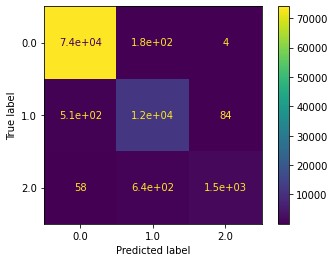

In [135]:
plot_confusion_matrix(est, X_trn, y_trn, normalize=None)
plt.show()

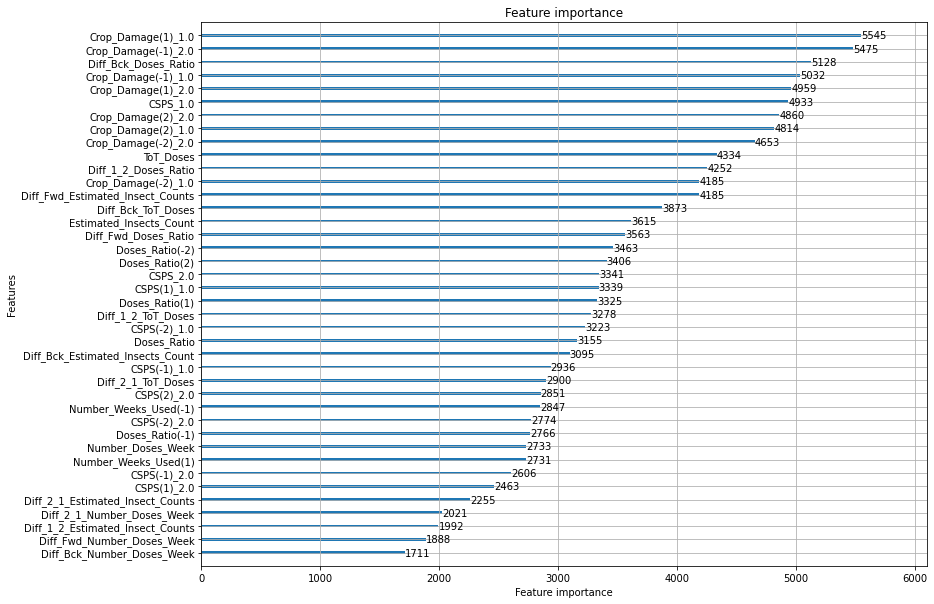

In [128]:
plot_importance(est, figsize=(13,10))
plt.show()

In [129]:
predicted = est.predict(X_tst)

In [130]:
Counter(predicted)

Counter({0.0: 49878, 1.0: 8426, 2.0: 1006})

In [131]:
df_sub['ID'] = df_tst['ID']
df_sub['Crop_Damage'] = predicted

In [132]:
df_sub.to_csv('submission_sel.csv', index=False, )

In [84]:
bag = BaggingClassifier(base_estimator=est, 
                        max_samples=1.0, 
                        max_features=1.0,
                        n_estimators=10, 
                        oob_score=False,
                        warm_start=True, 
                        n_jobs=-1,
                        bootstrap=True)

In [85]:
bag.fit(X_trn, y_trn)

BaggingClassifier(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                class_weight=None,
                                                colsample_by_node=0.5,
                                                colsample_bytree=1.0,
                                                importance_type='split',
                                                learning_rate=0.01,
                                                max_depth=-1,
                                                min_child_samples=1,
                                                min_child_weight=4.74,
                                                min_split_gain=0.0,
                                                n_estimators=2000, n_jobs=-1,
                                                num_leaves=20, objective=None,
                                                random_state=3, reg_alpha=1.74,
                                                reg_lambda=2.06, silent=Tr

In [ ]:
bag.oob_score_

0.9634923135789687

In [86]:
bag_prediction = bag.predict(X_tst)

In [87]:
Counter(bag_prediction)

Counter({0.0: 49905, 1.0: 8470, 2.0: 935})

In [88]:
df_sub['ID'] = df_tst['ID']
df_sub['Crop_Damage'] = bag_prediction

In [89]:
df_sub.to_csv('submission_sel_bag.csv', index=False)

In [ ]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=3)

In [ ]:
rf.fit(X_trn, y_trn)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=3, verbose=0,
                       warm_start=False)

In [ ]:
rf.oob_score_

0.9607688671813455